##**Differential IK as Optimization**

## Notebook Setup 
The following cell will install Drake, checkout the manipulation repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  

More details are available [here](http://manipulation.mit.edu/drake.html).

In [ ]:
import importlib
import os, sys
from urllib.request import urlretrieve

if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='dc0eb8aa32e271d9b5299a84435694d0565346af', drake_version='20200909', drake_build='nightly')

In [ ]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt, mpld3
from IPython.display import HTML, display

# Install pyngrok.
server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']

# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

from pydrake.all import (
    BasicVector, DiagramBuilder, ConnectMeshcatVisualizer, Integrator,
    JacobianWrtVariable, LeafSystem, Simulator, ConstantVectorSource,
    MathematicalProgram, Solve, eq, le, ge,
    GenerateHtml)

from pydrake.examples.manipulation_station import ManipulationStation

## Problem Description
In the lecture, we learned about how to view Differential inverse kinematics as an instance of optimization. In this exercise, we will actually define and solve these optimization problems!

The goal of the exercise is to see if you can apply the optimization techniques we learned in class to design your own controller.

**These are the main steps of the exercise:**
1. Write down the JacobianPseudoinverse controller as an optimization-based framework with joint-velocity constraints. 
2. Design and implement a virtual wall for the manipulator through constraints in the end-effector space. 

## The Differential IK System 

As we've seen in the lecture, a differential IK converts a desired end-effector velocity to joint velocities. From drake's system view of the world, how should we abstract this?

It would be reasonable to make it a `LeafSystem`, where the input is `spatial velocity_desired`, and the output is `iiwa_velocity_commanded`. We might also need an input port of `iiwa_position_measured` since our Jacobian is a function of the joint angles, and `iiwa_velocity_esimated` in case we want to use that information. 

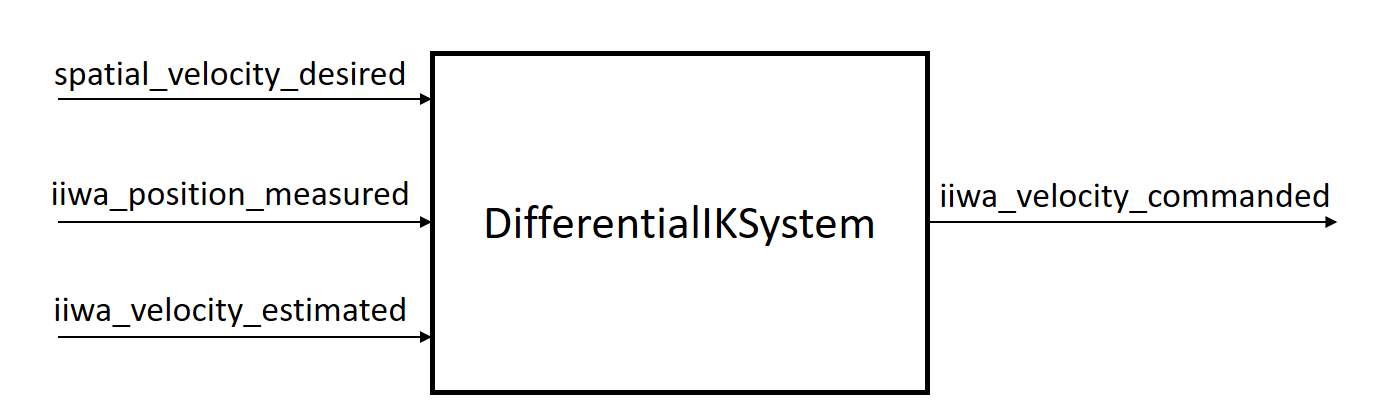

Since we will be going through different implementations of DifferentialIK, let's set up a DifferentialIKSystem that accepts a function to compute joint velocities upon getting the Jacobian, desired spatial velocity, and other information from the robot.

We will also abstract all the Drake workings into a wrapper `BuildAndSimulate`, which constructs and connects the following systems:
- `ManipulationStation`
- `DifferentialIKSystem` 
- `ConstantVectorSource` for commanding desired velocity to controller.
- `Integrator` to go from `iiwa_velocity` output of controller to `iiwa_position` input of `ManipulationStation`. 

The purpose of this function is to swap out different implementations of spatial-to-joint velocity mappings on the fly and simulate! 


In [ ]:
class DifferentialIKSystem(LeafSystem):
    """Wrapper system for Differential IK. 
        @param plant MultibodyPlant of the simulated plant. 
        @param diffik_fun function object that handles diffik. Must have the signature 
               diffik_fun(J_G, V_G_desired, q_now, v_now, X_now)
    """ 
    def __init__(self, plant, diffik_fun):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()
        self._diffik_fun = diffik_fun

        self.DeclareVectorInputPort("spatial_velocity", BasicVector(6))
        self.DeclareVectorInputPort("iiwa_position_measured", BasicVector(7))
        self.DeclareVectorInputPort("iiwa_velocity_measured", BasicVector(7))
        self.DeclareVectorOutputPort("iiwa_velocity_command", BasicVector(7), 
                                     self.CalcOutput)
        
    def CalcOutput(self, context, output):
        V_G_desired = self.get_input_port(0).Eval(context)
        q_now = self.get_input_port(1).Eval(context)
        v_now = self.get_input_port(2).Eval(context)

        self._plant.SetPositions(self._plant_context, self._iiwa, q_now)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kQDot, 
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,0:7] # Ignore gripper terms

        X_now = self._plant.CalcRelativeTransform(self._plant_context, 
                                                     self._W, self._G)
        p_now = X_now.translation()
        
        v = self._diffik_fun(J_G, V_G_desired, q_now, v_now, p_now) 
        output.SetFromVector(v)

def BuildAndSimulate(diffik_fun, V_d, plot_system_diagram=False):
  builder = DiagramBuilder()

  station = builder.AddSystem(ManipulationStation(time_step=4e-3))
  station.SetupClutterClearingStation()
  #station.SetupManipulationClassStation()
  station.Finalize()

  controller = builder.AddSystem(DifferentialIKSystem(
      station.get_multibody_plant(), diffik_fun))
  integrator = builder.AddSystem(Integrator(7))
  desired_vel = builder.AddSystem(ConstantVectorSource(V_d))

  builder.Connect(controller.get_output_port(), 
                  integrator.get_input_port())
  builder.Connect(integrator.get_output_port(),
                  station.GetInputPort("iiwa_position"))
  builder.Connect(station.GetOutputPort("iiwa_position_measured"),
                  controller.get_input_port(1))
  builder.Connect(station.GetOutputPort("iiwa_velocity_estimated"),
                  controller.get_input_port(2))
  builder.Connect(desired_vel.get_output_port(),
                  controller.get_input_port(0))

  meshcat = ConnectMeshcatVisualizer(builder,
      station.get_scene_graph(),
      output_port=station.GetOutputPort("pose_bundle"),
      delete_prefix_on_load=False, # support caching
      zmq_url=zmq_url)

  diagram = builder.Build()
  diagram.set_name("diagram")
  if (plot_system_diagram): (
      display(HTML('<script src="https://unpkg.com/gojs/release/go.js"></script>' + GenerateHtml(diagram)))
  )

  simulator = Simulator(diagram)
  station_context = station.GetMyContextFromRoot(simulator.get_mutable_context())
  station.GetInputPort("iiwa_feedforward_torque").FixValue(station_context, np.zeros((7,1)))
  station.GetInputPort("wsg_position").FixValue(station_context, [0.1])

  integrator.GetMyContextFromRoot(simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(station.GetIiwaPosition(station_context))

  simulator.set_target_realtime_rate(1.0)
  simulator.AdvanceTo(0.01);

  return simulator 

Let's just make sure we've got all the systems and connections right by hooking this up with out Baseclass controller `DifferentialIKBaseSystem` that outputs zero velocities, and looking at the diagram. 

For differential IK, we'll just set it up with a function that always outputs zeroes for now.

In [ ]:
def DiffIK_Zero(J_G, V_G_desired, q_now, v_now, p_now):
  return np.zeros(7)

V_d = np.zeros(6)
simulator = BuildAndSimulate(DiffIK_Zero, V_d, plot_system_diagram=True)

If you wait until the simulation is set up and advance the simulator by running the below cell, you should see that the manipulator just stays still since our base class keeps sending zero-velocity. 

In [ ]:
simulator.AdvanceTo(5.0)

## Differential IK through Inverse Jacobian

That was some setup to get through the basic tools, but now we're onto the main part of the set! In class, we've seen that in order to map a desired spatial velocity $V^G$ to desired joint velocities, we can use the relation 

$$V^G = J^G(q) v$$

and "invert" this with a Moore-Penrose pseudoinverse to achieve differential kinematics:

$$v = [J^G(q)]^{+} V^{G}$$

We can implement this controller fairly easily:

In [ ]:
def DiffIKPseudoInverse(J_G, V_G_desired, q_now, v_now, p_now):
  v = np.linalg.pinv(J_G).dot(V_G_desired)
  return v

Let's simulate this system forward. Run the cell below, and when the simulator is ready in Meshcat, advance the simulator in the second cell below. 

In [ ]:
# Corresponds to [wx, wy, wz, vx, vy, vz]
V_d = np.array([0., 0., 0., 0.1, 0.0, 0])
simulator = BuildAndSimulate(DiffIKPseudoInverse, V_d)

In [ ]:
simulator.AdvanceTo(7.0)

Wow - what just happened? There are several things you should have noticed.
- The robot did its job by going 0.1m/s in the x-direction (for anyone not familiar, there is a 'world-frame' axis colored by RGB. The usual convention is that RGB corresponds respectively to XYZ axii. Note that the robot is moving in the direction of the red axis as expected) 
- When the robot reached the end of its workspace, it freaked out, jerking unexpectedly.

Imagine thinking the PseudoInverse method was a good idea, implementing the controller, then running this in a real robot - something might have gone badly wrong! 

## Pseudoinverse as Optimization

Even though the method got unreliable at the limits of the kinematic workspace (i.e. under kinematic singularities), it worked reasonably well. How do we keep the benefits of the original method while improving behavior near singularities?

One idea presented in class is to stick to a certain **joint velocity limit**. This will at least prevent the manipulator from doing something crazy. 

**Now it's your turn to code!**

In the language of optimization, the problem we are trying to solve will look like: 

$$\begin{aligned}
\min_v \quad & \|\mathbf{J}(q)v - V_d\|^2_2 \\
\textrm{s.t.} \quad &  |v|\leq v_{max} \end{aligned}$$

Below, you must transcribe and solve this optimization problem through `MathematicalProgram`. 

NOTE: The absolute value is taken element wise, so the last constraint is really saying "for all $i$, make sure none of the elements of $|v[i]|$ exceed $v_{max}[i]$. Such constraints are also called Bounding Box constraints. 

HINT: We can't directly enter absolute values as a constraint in `MathematicalProgram`, but we can break down the absolute value constraint into two separate constraints. 

NOTE: If you're not familiar with how to write down mathematical program, make sure you do the `intro_to_qp` exercise on the textbook first. If you're still stuck, feel free to get more practice from [this notebook tutorial](https://mybinder.org/v2/gh/RobotLocomotion/drake/nightly-release-binder?filepath=tutorials/mathematical_program.ipynb), or look at the [`pydrake` documentation on `MathematicalProgram`](https://drake.mit.edu/pydrake/pydrake.solvers.mathematicalprogram.html). 

In [ ]:
def DiffIKQP(J_G, V_G_desired, q_now, v_now, p_now):

  prog = MathematicalProgram()
  v = prog.NewContinuousVariables(7, 'v')
  v_max = 3.0 # do not modify 

  # Add cost and constraints to prog here.
  
  result = Solve(prog)
        
  if not (result.is_success()):
    raise ValueError("Could not find the optimal solution.")

  v_solution = result.GetSolution(v)

  return v_solution

When you're ready to test out your new method, you can run the simulator to see what happens. Similar to last time, wait until everything loads on Meshcat and run the second cell below to simulate forward. 

In [ ]:
V_d = np.array([0., 0., 0., 0.1, 0., 0.]) # Feel free to play around with different V_desired
simulator = BuildAndSimulate(DiffIKQP, V_d)

In [ ]:
simulator.AdvanceTo(7.0)

When you have implemented things correctly, you should see we behave much better near singularities now, since we're constraining joint velocities. This is nice - even if the Jacobian becomes singular, we can guard against sudden jerky movements because we've put limits.

## An Virtual Wall in End-Effector Space

In class, we saw that in addition to doing joint velocity constraints, we can also put constraints on **joint positions** and **accelerations** through first-order Euler finite difference. Given $v_{now}$ and $q_{now}$, we can find $v$ that satisfies the following program:

$$\begin{aligned}
\min_v \quad & \|\mathbf{J}(q_{now})v - V_d\|^2_2 \\
\textrm{s.t.} \quad &  |v|\leq v_{max} \\ 
\quad & q_{min} \leq q_{now} + h v \leq q_{max} \\
\quad & a_{min} \leq (v-v_{now})/h \leq a_{max}\end{aligned}$$

All of these constraints are formulated in the joint-space. But could we also end up with a linear constraint if we try to impose a constraint in the end-effector space? 

**Now it's your time to code!**

You must program a robot in a factory, but you would like to implement a virtual wall that the robot is not allowed to put its hand in, since you have limited space and a human will be working there, or there are some obstacles there. 

To do this, you decide to write an optimization-based controller that minimizes $\|\mathbf{J}(q_{now})v - V_d\|_2^2$ and has two constraints:
1. Joint velocity constraint $|v|\leq v_{max}$
2. A constraint that the **position** of the end-effector must be inside the following box:
  - `lower_bound = [-0.3, -1.0, -1.0]`
  - `upper_bound = [0.3, 1.0, 1.0]`

You can access the current position of the robot by using `p_now` (found by running forward kinematics). 

HINT: We can similarly use first-order approximations to query what the next position will be given the current position and velocities in the end-effector space. 

In [ ]:
def DiffIKQP_Wall(J_G, V_G_desired, q_now, v_now, p_now):
      prog = MathematicalProgram()
      v = prog.NewContinuousVariables(7, 'joint_velocities')
      v_max = 3.0 # do not modify
      h = 4e-3 # do not modify
      lower_bound = np.array([-0.3, -1.0, -1.0]) # do not modify
      upper_bound = np.array([0.3, 1.0, 1.0]) # do not modify

      # Fill in your code here. 

      result = Solve(prog)

      if not (result.is_success()):
        raise ValueError("Could not find the optimal solution.")

      v_solution = result.GetSolution(v)
      return v_solution

In [ ]:
V_d = np.array([0.0, 0., 0., 0.1, 0.05, 0])
simulator = BuildAndSimulate(DiffIKQP_Wall, V_d)

In [ ]:
# Wait for the model to load in the visualizer, then run this cell to see the interesting part...
simulator.AdvanceTo(7.0);

If you implemented this correctly, it will seem like the robot has a virtual wall that it cannot cross! 


##How will this notebook be Graded?##

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

For submission of this assignment, you must do as follows:. 
- Download and submit the notebook `differential_ik_optimization.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [4 pts] `DiffIKQP` must be implemented correctly. 
- [6 pts] `DiffIKQP_Wall` must be implemented correctly. 

Below is our autograder where you can check the correctness of all your implementations. 

In [ ]:
from manipulation.exercises.pick.test_differential_ik import TestDifferentialIK
from manipulation.exercises.grader import Grader 

Grader.grade_output([TestDifferentialIK], [locals()], 'results.json')
Grader.print_test_results('results.json')